In [2]:
from sklearn.externals import joblib
import seaborn as sns
sns.set_context("paper", rc={"font.size":150, "axes.titlesize":15, "axes.labelsize":15})   
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import scipy
import pprint

# check data

In [2]:
save_data_path = "mixture_of_experts_project/data/mortality_24/"
X = np.load(save_data_path + 'X.npy')
# jw: need to allow_pickle=True                                                                                                                                                                                 
careunits = np.load(save_data_path + 'careunits.npy', allow_pickle=True)
saps_quartile = np.load(save_data_path + 'saps_quartile.npy')
subject_ids = np.load(save_data_path + 'subject_ids.npy')
Y = np.load(save_data_path + 'Y.npy')

pd_dict = {}
all_tasks = sorted(np.unique(careunits))
for task in all_tasks:
    subset = (careunits == task)
    n_samples = sum(subset)
    n_pos_samples = sum(Y[subset])
    pd_dict[task] = {'N': n_samples, 'n': n_pos_samples, 'Class Imbalance': float(n_pos_samples) / n_samples}

df = pd.DataFrame.from_dict(pd_dict).T
df2 = pd.DataFrame.from_dict({'Overall': {'N': len(Y), 'n': sum(Y), 'Class Imbalance': float(sum(Y)) / len(Y)}}).T
df = df.append(df2)
df[['N', 'n']].astype(int)

,N,n
CCU,4888,340
CSRU,6977,136
MICU,11429,1120
SICU,5183,398
TSICU,4234,284
Overall,32711,2278


# check model

In [7]:
exp_names = ['moe_exp', 'global_exp', 'MTL_careunit_exp',
             'snapshot_careunit_exp', 
             'separate_careunit_exp']
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames:
        pd_dict[str(run)] =np.load('mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))
    
choose_val_criterion = 'Micro' # can only be Macro or Micro
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))

pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        val_micro_auc = np.load('mixture_of_experts_project/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            pd_dict[exp_name] = np.load(val_best_name[exp_name])    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    

df.round(3)[exp_names]


moe_exp
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.859   0.883   0.792   0.838   0.829   0.840   0.842
std     0.070   0.072   0.062   0.062   0.064   0.066   0.068
min     0.503   0.510   0.479   0.518   0.503   0.503   0.492
25%     0.863   0.888   0.799   0.847   0.834   0.849   0.852
50%     0.876   0.897   0.805   0.850   0.842   0.855   0.856
75%     0.883   0.903   0.809   0.854   0.847   0.859   0.860
max     0.890   0.929   0.832   0.866   0.865   0.865   0.870

global_exp
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.858   0.887   0.798   0.836   0.830   0.842   0.844
std     0.071   0.069   0.041   0.065   0.056   0.060   0.060
min     0.498   0.536   0.594   0.506   0.539   0.535   0.536
25%     0.866   0.887   0.805   0.846   0.835   0.850   0.854
50%     0.873   0.900   0.808   0.851   0.842   0

,moe_exp,global_exp,MTL_careunit_exp,snapshot_careunit_exp,separate_careunit_exp
CCU,0.875,0.868,0.884,0.827,0.845
CSRU,0.885,0.910,0.876,0.901,0.923
MICU,0.813,0.808,0.819,0.803,0.810
SICU,0.866,0.856,0.854,0.842,0.814
TSICU,0.840,0.837,0.852,0.811,0.819
Macro,0.856,0.856,0.857,0.837,0.842
Micro,0.861,0.859,0.868,0.842,0.846


In [8]:
pprint.pprint(val_best)
pprint.pprint(val_best_name)

{'MTL_careunit_exp': 0.873141405930205,
 'global_exp': 0.874821995837441,
 'moe_exp': 0.8731817631492468,
 'separate_careunit_exp': 0.8586430749894782,
 'snapshot_careunit_exp': 0.8601434987402783}
{'MTL_careunit_exp': 'mixture_of_experts_project/mortality_test/results/test_auc_on_18_single_MTL_careunit_exp.npy',
 'global_exp': 'mixture_of_experts_project/mortality_test/results/test_auc_on_10_single_global_exp.npy',
 'moe_exp': 'mixture_of_experts_project/mortality_test/results/test_auc_on_20_single_moe_exp.npy',
 'separate_careunit_exp': 'mixture_of_experts_project/mortality_test/results/test_auc_on_18_single_separate_careunit_exp.npy',
 'snapshot_careunit_exp': 'mixture_of_experts_project/mortality_test/results/test_auc_on_10_single_snapshot_careunit_exp.npy'}


In [9]:
exp_names = ['MTL_saps_exp', 'snapshot_saps_exp', 'separate_saps_exp']
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames:
        pd_dict[str(run)] =np.load('mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'q1', 1: 'q2', 2: 'q3', 3: 'q4', 4: 'Macro', 5: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))
    
choose_val_criterion = 'Micro' # can only be Macro or Micro
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))
pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        val_micro_auc = np.load('mixture_of_experts_project/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            pd_dict[exp_name] = np.load(val_best_name[exp_name])    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'q1', 1: 'q2', 2: 'q3', 3: 'q4', 4: 'Macro', 5: 'Micro'}, axis='index')    
df.round(3)[exp_names]


MTL_saps_exp
           q1      q2      q3      q4   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.818   0.784   0.714   0.754   0.767   0.854
std     0.136   0.110   0.072   0.088   0.100   0.032
min     0.363   0.412   0.500   0.498   0.445   0.761
25%     0.838   0.803   0.722   0.781   0.794   0.858
50%     0.861   0.818   0.738   0.787   0.802   0.867
75%     0.878   0.836   0.746   0.790   0.809   0.870
max     0.913   0.859   0.779   0.800   0.822   0.873

snapshot_saps_exp
           q1      q2      q3      q4   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.782   0.775   0.704   0.762   0.756   0.832
std     0.142   0.042   0.034   0.027   0.053   0.034
min     0.407   0.633   0.602   0.699   0.634   0.750
25%     0.701   0.755   0.690   0.743   0.734   0.827
50%     0.870   0.779   0.710   0.769   0.771   0.841
75%     0.893   0.806   0.729   0.784   0.796   0.854
max     0.917   0.830   0.745   0.795   0.821   0

,MTL_saps_exp,snapshot_saps_exp,separate_saps_exp
q1,0.842,0.911,0.849
q2,0.819,0.830,0.797
q3,0.755,0.737,0.710
q4,0.792,0.791,0.784
Macro,0.802,0.817,0.785
Micro,0.868,0.868,0.858


In [17]:
exp_names = ['global_plus_mtl_exp', 'ae_plus_mtl_exp', 
             'val_curve_plus_mtl_exp', 
             'global_plus_snapshot_exp', 
             'val_curve_plus_snapshot_exp'
            ]
runnames = list(range(30))

pds = {}
for exp_name in exp_names:
    pd_dict = {}
    for run in runnames: 
        try: # figure out what's wrong with somd of the runs
            pd_dict[str(run)] =np.load('mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))[-2:]
        except:
            print("{} missing run {}".format(exp_name, run))
            continue

    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
    # df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[exp_name] = df.transpose()

for exp_name in exp_names:
    print('\n' + exp_name)
    print(pds[exp_name].describe().round(3))
    
choose_val_criterion = 'Micro' # can only be Macro or Micro; here only make sense for Micro b/c they have different clusters
choose_val_idx = -1 if choose_val_criterion == 'Micro' else -2
print('Choosing hyperparameter using {} auc'.format(choose_val_criterion))

pd_dict = {}
val_best = {}
val_best_name = {}
for exp_name in exp_names:
    for run in runnames:
        try: # figure out what's wrong with some of the runs
            val_micro_auc = np.load('mixture_of_experts_project/mortality_test/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))[choose_val_idx]
            np.load('mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))
        except:
            print("{} missing run {}".format(exp_name, run))
            continue
            
        if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
            val_best[exp_name] = val_micro_auc
            val_best_name[exp_name] = 'mixture_of_experts_project/mortality_test/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name)
            
            pd_dict[exp_name] = np.load(val_best_name[exp_name])[-2:]
    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'Macro', 1: 'Micro'}, axis='index')    
# df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[exp_names]


global_plus_mtl_exp
        Macro   Micro
count  30.000  30.000
mean    0.606   0.825
std     0.083   0.036
min     0.478   0.707
25%     0.518   0.811
50%     0.630   0.838
75%     0.668   0.851
max     0.747   0.858

ae_plus_mtl_exp
        Macro   Micro
count  30.000  30.000
mean    0.795   0.830
std     0.119   0.066
min     0.445   0.581
25%     0.816   0.850
50%     0.839   0.854
75%     0.856   0.857
max     0.868   0.864

val_curve_plus_mtl_exp
        Macro   Micro
count  30.000  30.000
mean    0.741   0.816
std     0.118   0.062
min     0.491   0.618
25%     0.727   0.803
50%     0.781   0.844
75%     0.832   0.850
max     0.863   0.864

global_plus_snapshot_exp
        Macro   Micro
count  30.000  30.000
mean    0.639   0.832
std     0.062   0.051
min     0.506   0.574
25%     0.596   0.830
50%     0.649   0.846
75%     0.668   0.853
max     0.754   0.858

val_curve_plus_snapshot_exp
        Macro   Micro
count  30.000  30.000
mean    0.764   0.837
std     0.062   0.023
min

,global_plus_mtl_exp,ae_plus_mtl_exp,val_curve_plus_mtl_exp,global_plus_snapshot_exp,val_curve_plus_snapshot_exp
Macro,0.627,0.867,0.776,0.661,0.698
Micro,0.850,0.864,0.856,0.856,0.853


## randomness (lr=0.0001 and lr=0.001)

In [63]:
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]
runs = range(1, 31)
pds = {}
for fn in fns:
    pd_dict = {}
    for run in runs:
        if fn in ['global', 'multitask', 'separate']: # original code
            pd_dict['run' + str(run)] =np.load('clean_template/clean_template_after_data_change/mortality_test/results/test_auc_on_{}_single{}.npy'.format(fn, run))
        else:
            pd_dict['run' + str(run)] =np.load('clean_template/clean_template_after_data_change/mortality_test/results/test_auc_on_{}single{}.npy'.format(fn, run))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[fn] = df.transpose()

for fn in fns:
    print('\n' + fn)
    print(pds[fn].describe().round(3))
    
pd_dict = {}
val_best = {}
for fn in fns:
    for run in runs:
        if fn in ['global', 'multitask', 'separate']: # original code
            val_micro_auc = np.load('clean_template/clean_template_after_data_change/mortality_test/results/{}_model_results_no_sample_weights{}.npy'.format(fn, run))[0][-1][-1]
        else:
            val_micro_auc = np.load('clean_template/clean_template_after_data_change/mortality_test/results/val_auc_on_{}single{}.npy'.format(fn, run))[-1]
        if not val_best.get(fn) or val_best[fn] < val_micro_auc:
            val_best[fn] = val_micro_auc
            if fn in ['global', 'multitask', 'separate']: # original code
                pd_dict[fn] = np.load('clean_template/clean_template_after_data_change/mortality_test/results/test_auc_on_{}_single{}.npy'.format(fn, run))    
            else:
                pd_dict[fn] = np.load('clean_template/clean_template_after_data_change/mortality_test/results/test_auc_on_{}single{}.npy'.format(fn, run))    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[fns]


global
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.865   0.894   0.801   0.837   0.840   0.848   0.851
std     0.009   0.014   0.006   0.009   0.012   0.005   0.004
min     0.850   0.852   0.790   0.810   0.818   0.832   0.842
25%     0.861   0.886   0.798   0.833   0.831   0.844   0.849
50%     0.864   0.895   0.801   0.838   0.840   0.848   0.851
75%     0.870   0.902   0.804   0.842   0.848   0.850   0.853
max     0.887   0.931   0.817   0.855   0.864   0.861   0.861

global_pytorch
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.874   0.894   0.800   0.842   0.829   0.848   0.849
std     0.008   0.013   0.008   0.007   0.009   0.004   0.005
min     0.851   0.864   0.783   0.831   0.813   0.837   0.839
25%     0.870   0.885   0.794   0.836   0.820   0.845   0.845
50%     0.876   0.895   0.801   0.841   0.830 

,global,global_pytorch,multitask,mtl_pytorch,moe
CCU,0.864,0.861,0.876,0.858,0.878
CSRU,0.906,0.909,0.885,0.858,0.879
MICU,0.802,0.783,0.815,0.799,0.804
SICU,0.844,0.835,0.846,0.839,0.849
TSICU,0.841,0.824,0.846,0.850,0.853
Macro,0.852,0.842,0.854,0.841,0.853
Micro,0.854,0.840,0.859,0.851,0.855


In [79]:
fns = [
    'global',
    'global_pytorch',
    'multitask',
    'mtl_pytorch',
    'moe'
]
runs = range(1, 31)
suffix = '_lr'
pds = {}
for fn in fns:
    pd_dict = {}
    for run in runs:
        pd_dict['run' + str(run)] =np.load('clean_template/clean_template_after_data_change/mortality_test/results/test_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))    
    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
    pds[fn] = df.transpose()

for fn in fns:
    print('\n' + fn)
    print(pds[fn].describe().round(3))
    
pd_dict = {}
val_best = {}
for fn in fns:
    for run in runs:
        if fn in ['global', 'multitask', 'separate']: # original code
            val_micro_auc = np.load('clean_template/clean_template_after_data_change/mortality_test/results/{}_model_results_no_sample_weights{}{}.npy'.format(fn, run, suffix))[0][-1][-1]
        else:
            val_micro_auc = np.load('clean_template/clean_template_after_data_change/mortality_test/results/val_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))[-1]
        if not val_best.get(fn) or val_best[fn] < val_micro_auc:
            val_best[fn] = val_micro_auc
            pd_dict[fn] = np.load('clean_template/clean_template_after_data_change/mortality_test/results/test_auc_on_{}_single{}{}.npy'.format(fn, run, suffix))    
df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
df.round(3)[fns]


global
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.866   0.888   0.801   0.829   0.851   0.847   0.850
std     0.014   0.022   0.013   0.015   0.013   0.011   0.010
min     0.841   0.808   0.755   0.780   0.818   0.801   0.810
25%     0.856   0.878   0.797   0.823   0.843   0.843   0.846
50%     0.865   0.892   0.804   0.832   0.852   0.848   0.851
75%     0.877   0.901   0.810   0.839   0.860   0.854   0.856
max     0.895   0.929   0.816   0.860   0.879   0.861   0.862

global_pytorch
          CCU    CSRU    MICU    SICU   TSICU   Macro   Micro
count  30.000  30.000  30.000  30.000  30.000  30.000  30.000
mean    0.875   0.895   0.806   0.851   0.836   0.853   0.855
std     0.005   0.011   0.007   0.008   0.008   0.004   0.004
min     0.865   0.870   0.788   0.831   0.824   0.845   0.848
25%     0.872   0.887   0.803   0.848   0.829   0.849   0.853
50%     0.875   0.893   0.806   0.852   0.838 

,global,global_pytorch,multitask,mtl_pytorch,moe
CCU,0.883,0.873,0.862,0.869,0.874
CSRU,0.886,0.890,0.876,0.862,0.898
MICU,0.813,0.809,0.787,0.812,0.804
SICU,0.834,0.861,0.835,0.856,0.847
TSICU,0.837,0.846,0.851,0.848,0.833
Macro,0.851,0.856,0.842,0.849,0.851
Micro,0.856,0.858,0.847,0.861,0.854


# default setting (paper result)

In [14]:
'''
if error occurs need to rerun "make careunit_test" b/c global result is overwritten
no need to retrain though
'''
fns = [
    #'global',
    'multitask',
]
pd_dict = {}
for fn in fns:
    if fn == 'multitask':
        pd_dict[fn] = np.load('mixture_of_experts_project/previous_result/mortality_test/results/test_auc_on_{}_singlecareunit.npy'.format(fn))
    else:
        pd_dict[fn] = np.load('mixture_of_experts_project/previous_result/mortality_test/results/test_auc_on_{}_single.npy'.format(fn))
pd.DataFrame.from_dict(pd_dict)

df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')
df.round(3)[fns]

,multitask
CCU,0.866
CSRU,0.865
MICU,0.803
SICU,0.820
TSICU,0.841
Macro,0.839
Micro,0.846


In [13]:
'''
if error occurs need to rerun "make careunit_custom" b/c global result is overwritten
no need to retrain though
'''

fns = [
    'global',
    'multitask',
]
pd_dict = {}
for fn in fns:
    pd_dict[fn] = np.load('mixture_of_experts_project/previous_result/mortality_test/results/test_auc_on_{}_single.npy'.format(fn))
pd.DataFrame.from_dict(pd_dict)

df = pd.DataFrame.from_dict(pd_dict)
df = df.rename({3: 'Macro', 4: 'Micro'}, axis='index')
df.round(3)[fns]

,global,multitask
0,0.795,0.788
1,0.805,0.808
2,0.511,0.540
Macro,0.704,0.712
Micro,0.846,0.849


# Visualize clusters

In [88]:
save_data_path = "mixture_of_experts_project/data/mortality_24/"
cluster_assignment = np.load('mixture_of_experts_project/cluster_membership/test_clusters.npy')
X = np.load(save_data_path + 'X.npy')
# jw: need to allow_pickle=True                                                                                                                                                                                 
careunits = np.load(save_data_path + 'careunits.npy', allow_pickle=True)
saps_quartile = np.load(save_data_path + 'saps_quartile.npy')
subject_ids = np.load(save_data_path + 'subject_ids.npy')
Y = np.load(save_data_path + 'Y.npy')

In [96]:
for i in range(4):
    print("saps quartile {} has mortality rate {:.2f}".format(i, Y[saps_quartile == i].mean()))

saps quartile 0 has mortality rate 0.01
saps quartile 1 has mortality rate 0.03
saps quartile 2 has mortality rate 0.07
saps quartile 3 has mortality rate 0.19


In [155]:
y_pred_val, y_val, cohorts_val = joblib.load('mixture_of_experts_project/mortality_test/results/output_debug.pkl')

Text(0,0.5,'y val')

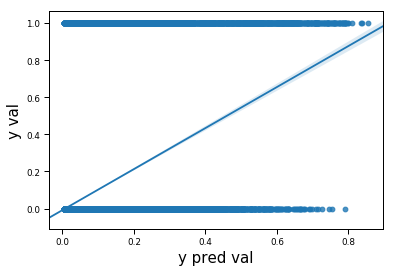

In [156]:
sns.regplot(y_pred_val, y_val)
plt.xlabel('y pred val')
plt.ylabel('y val')

In [157]:
n_cut = 4
cutoffs = np.percentile(y_pred_val, np.linspace(0, 100, n_cut+1))
y_pred_quartile = np.zeros(len(y_pred_val))
for i in range(n_cut):
    c = np.logical_and(y_pred_val > cutoffs[i], y_pred_val <= cutoffs[i+1])
    y_pred_quartile[c] = i

In [158]:
for i in range(n_cut):
    print("y pred val quartile {} has mortality rate {:.2f}".format(i, y_val[y_pred_quartile == i].mean()))

y pred val quartile 0 has mortality rate 0.00
y pred val quartile 1 has mortality rate 0.01
y pred val quartile 2 has mortality rate 0.03
y pred val quartile 3 has mortality rate 0.23


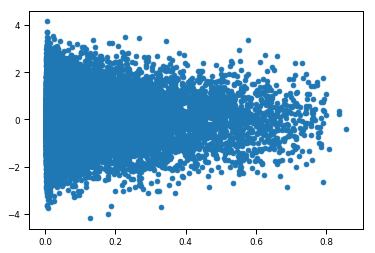

In [159]:
plt.scatter(y_pred_val, np.random.randn(len(y_pred_val)))

In [165]:
np.save('mixture_of_experts_project/cluster_membership/sample_y_quartile', y_pred_quartile)